This notebook was used to test and have a right definition of simulate_neuron function introducing the parameters of plasticity. Same purpose as Test Run notebook - but this one's last purpose was to test simulate_neuron fro learning rate parameters

In [16]:
import numpy as np
from Utils import *
import matplotlib.pyplot as plt
from numba import njit
import seaborn as sns

import numba as nb
from tqdm import tqdm as tqdm

In [17]:
# Simulation Parameters

E_inputs = 200
I_inputs = 50
Groups = 10


time = 100000 # ms
dt = 0.1  # ms
timesteps=int(time/dt)
pulse_time = 50
tau = 2.0 # ms # tau is the activity time scale 
    
noise = 0.01
dendrite_leak = 0 #0  #-0.01
#nonlinparams = np.array([0.0, 1.0, 1.0, 1.0, -600, 0.065])
#nonlinparams = np.array([0.0, 1.0, 1.0, 1.0, -900.754944, 0.08])
I_delay = 0
scale = 2 #0.5


In [18]:
# Dendritic structure

# Setting number of dendrites as the number of groups 
num_dend = Groups

re = 0.03
ri = 0.03
# W_dend_E is (200,10), binary matrix that indicate which neuron belong to each group in a shuffled way np.sum(W_dend_E, axis=0) = array of 1x10 -
W_dend_E = get_input_matrix(num_dend, E_inputs, re)
W_dend_I = get_input_matrix(num_dend, I_inputs, ri)

In [19]:
# Parameters
# Total synaptic weight
e_target = 5.0

# Total synaptic weight inhibitory
i_target = 1.5
"""
# Excitatory
# Learning rate excitatory
eta_e = 0.0001
# Total synaptic weight
e_target = 5.0
# Plasticity parameters
alpha_e = 1.0 # Power of pre-synaptic activity
beta_e = 0.0 # Power of post-synaptic activity
gamma_e = 0.0 #
delta_e = 0.0 # Power of the weights

# Inhibitory
# Learning rate inhibitory
eta_i = 0.0002
# Total synaptic weight inhibitory
i_target = 1.5
alpha_i = 1.0 # Power of pre-synaptic activity
beta_i = 0.0 # Power of post-synaptic activity
gamma_i = 0.0 
delta_i = 0.0 # Power of the weights

""" 

'\n# Excitatory\n# Learning rate excitatory\neta_e = 0.0001\n# Total synaptic weight\ne_target = 5.0\n# Plasticity parameters\nalpha_e = 1.0 # Power of pre-synaptic activity\nbeta_e = 0.0 # Power of post-synaptic activity\ngamma_e = 0.0 #\ndelta_e = 0.0 # Power of the weights\n\n# Inhibitory\n# Learning rate inhibitory\neta_i = 0.0002\n# Total synaptic weight inhibitory\ni_target = 1.5\nalpha_i = 1.0 # Power of pre-synaptic activity\nbeta_i = 0.0 # Power of post-synaptic activity\ngamma_i = 0.0 \ndelta_i = 0.0 # Power of the weights\n\n'

In [20]:
# Get Inputs
E_currents, I_currents, angle = get_EI_input(noise = noise,
                                             E_inputs = E_inputs,
                                             I_inputs = I_inputs,
                                             Groups = Groups,
                                             scale = scale,
                                             pulse_time = pulse_time,
                                             time = time,
                                             dt = dt,
                                            I_delay =   I_delay)
# E_currents (timesteps, neurons) - each group of 10 neurons has the same activity
# angle - (pulses,) - the orientation selected at each pulse 

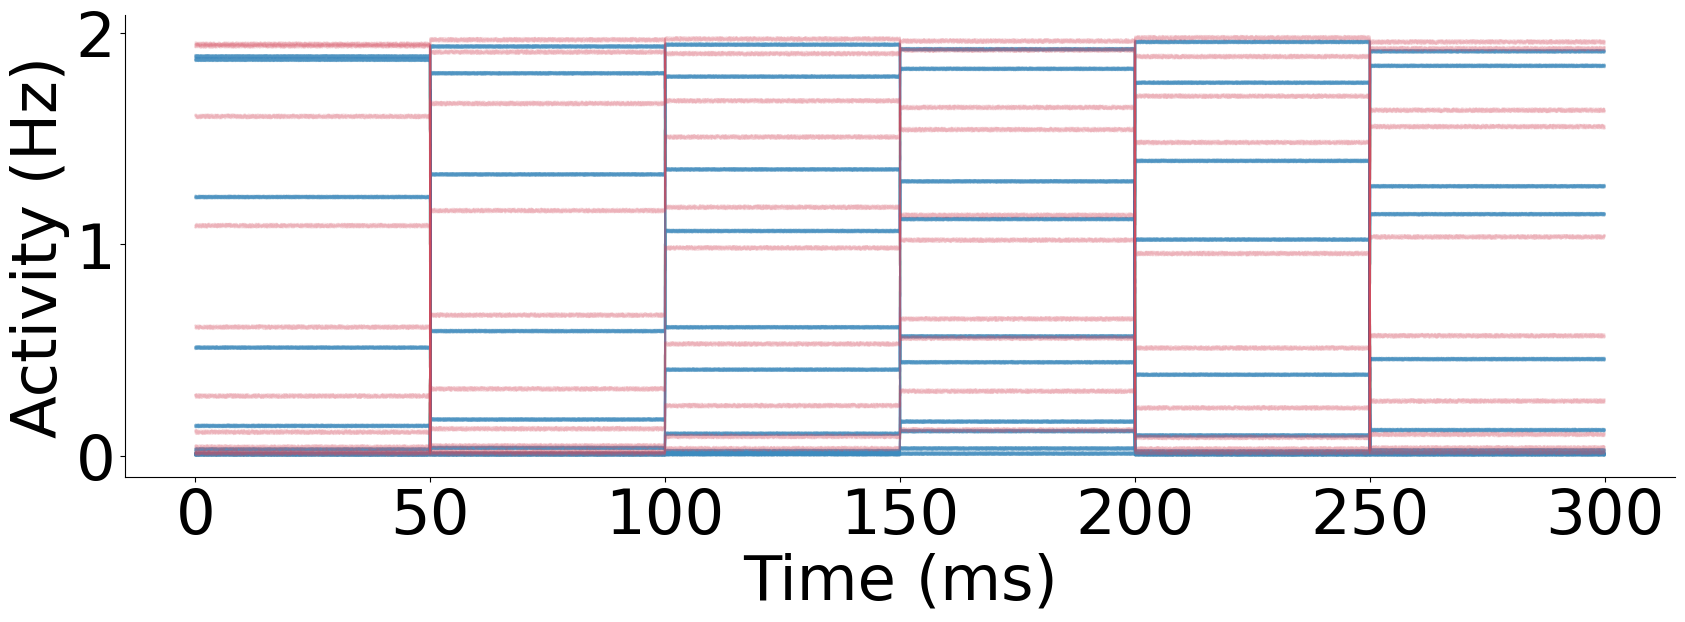

In [21]:
plt.rcParams.update({'font.size': 45})

plt.figure(figsize= (20, 6))
plt.plot(np.linspace(0, 300, 3000), E_currents[0:3000, 0:200], color = '#3d8bbeff', alpha = 0.1);
plt.plot(np.linspace(0, 300, 3000),I_currents[0:3000, 0:50], color = '#d74c5eff', alpha = 0.1);

plt.xlabel('Time (ms)')
plt.ylabel('Activity (Hz)')

sns.despine()

In [22]:
# I DONT NEED THE DENDRITIC NON-LINEARITY
"""
plt.rcParams.update({'font.size': 25})

#nonlinparams = np.array([0.0, 1.0, 1.0, 1.0, -600, 0.065])

x = np.linspace(-0.03, 0.2, 100)

plt.plot(x, x, '--k', alpha = 0.9)
plt.axhline(y = 0, linestyle = '--', color = 'r', alpha = 0.5)

plt.plot(x, non_lin(x, params=nonlinparams, nonlin=False), linewidth = 3)

plt.xlabel('x')
plt.ylabel(r'$\sigma(x)$')
plt.title('Dendritic Nonlinearity')

sns.despine()
"""


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2663690/3972009334.py:2: SyntaxWarning: invalid escape sequence '\s'
  """


"\nplt.rcParams.update({'font.size': 25})\n\n#nonlinparams = np.array([0.0, 1.0, 1.0, 1.0, -600, 0.065])\n\nx = np.linspace(-0.03, 0.2, 100)\n\nplt.plot(x, x, '--k', alpha = 0.9)\nplt.axhline(y = 0, linestyle = '--', color = 'r', alpha = 0.5)\n\nplt.plot(x, non_lin(x, params=nonlinparams, nonlin=False), linewidth = 3)\n\nplt.xlabel('x')\nplt.ylabel(r'$\\sigma(x)$')\nplt.title('Dendritic Nonlinearity')\n\nsns.despine()\n"

In [23]:
#### Simulation ####

@nb.njit
def simulate(params, timesteps=int(time/dt)):

    
    # Excitatory
    # Learning rate excitatory
    eta_e = 0.001
    # Total synaptic weight
    e_target = 5.0
    # Plasticity parameters
    alpha_e = 1.0 #params[0] 
    beta_e = 0.0 #params[1] 
    gamma_e = 0.0 #params[2]
    delta_e = 0.0 #params[3] 

    # Inhibitory
    # Learning rate inhibitory
    eta_i = 0.002
    # Total synaptic weight inhibitory
    i_target = 1.5
    alpha_i = 1.0 #params[4] 
    beta_i = 0.0 #params[5] 
    gamma_i = 0.0 #params[6] 
    delta_i = 0.0 #params[7] 
    
    # initialize rate of postsynaptic neuron
    r = np.zeros(timesteps)
    # initialize voltage of postsynaptic neuron
    v = np.zeros(timesteps)
    
    # initial values at t = 0 
    r[0] = 0.01
    v = 0.25

    # initialize weights to the specific target 
    w_e = e_target * np.random.rand(timesteps, E_inputs) / E_inputs
    w_i = i_target * np.random.rand(timesteps, I_inputs) / I_inputs

    
    E_target = e_target * np.ones(timesteps)

    # Simulate learning
    for t in range(1, timesteps-1):
        # sum of inputs
        x = (w_e[t] * E_currents[t])@W_dend_E - (w_i[t] * I_currents[t])@W_dend_I # + dendrite_leak * v
        #print(x.shape)
        # WE ARE NOT USING IT -non-linearity of the dendrite
        # QUESTION: we dont apply any non-linearity to the input?
        #inp = np.sum(non_lin(x, params=nonlinparams, nonlin=False))
        inp = np.sum(x)
        #print(inp.shape)
        
        #delta_v = -v / tau + inp
        delta_v = (-v + inp) / tau
        v = v + dt * delta_v
        
        r[t] = rate(v)

        # STDP
        w_e[t+1] = np.maximum(w_e[t] + eta_e * dt * stdp(E_currents[t], r[t], alpha_e, beta_e, gamma_e, delta_e), 0)
        w_i[t+1] = np.maximum(w_i[t] + eta_i * dt * stdp(I_currents[t], r[t], alpha_i, beta_i, gamma_i, delta_i), 0)
        #w_e[t+1] = np.maximum(w_e[t] + dt * eta_e * stdp(E_currents[t], r[t]), 0)
        #w_i[t+1] = np.maximum(w_i[t] + dt * eta_i * stdp(I_currents[t], r[t]), 0)

        # Meta-Plasticity
        E_target[t+1] = E_target[t] - 0.25*eta_e*dt*(r[t] - r[0])

        # Normalization
        w_e[t+1] = w_e[t+1] * E_target[t+1] / np.sum(w_e[t+1])
        w_i[t+1] = w_i[t+1] * i_target / np.sum(w_i[t+1])

    return w_e, w_i, r, E_target

In [24]:
params= np.array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0])
w_e, w_i, r, E_target = simulate(params)

# CODE FROM UTILS
# w_e, w_i, r, E_target = simulate_neuron_plasticity(e_target = 5.0,
#                                                    i_target = 1.5, nonlinparams = nonlinparams, 
#                                                    E_inputs = 200, 
#                                                    I_inputs = 50, 
#                                                    E_currents = E_currents, I_currents = I_currents, 
#                                                    W_dend_E = W_dend_E, W_dend_I = W_dend_I, 
#                                                    dendrite_leak = 0, 
#                                                    tau = 20, dt = 0.1, 
#                                                    params = params, time= 180000)

In [25]:
#w_e, w_i, r, E_target = simulate_neuron_plasticity(e_target = 5.0,
                                                    # i_target = 1.5, nonlinparams = nonlinparams, 
                                                   # E_inputs = 200, 
                                                   # I_inputs = 50, 
                                                    # E_currents = E_currents, I_currents = I_currents, 
                                                    # W_dend_E = W_dend_E, W_dend_I = W_dend_I, 
                                                    # dendrite_leak = 0, 
                                                   # tau = 2, dt = 0.1, 
                                                   # params = params, time= 180000)

In [26]:
get_losses(w_e, w_i)

(0.017842402738894793, 0.02927423224979242, 0.00015884251142406154)

Text(0, 0.5, 'Synaptic Weight')

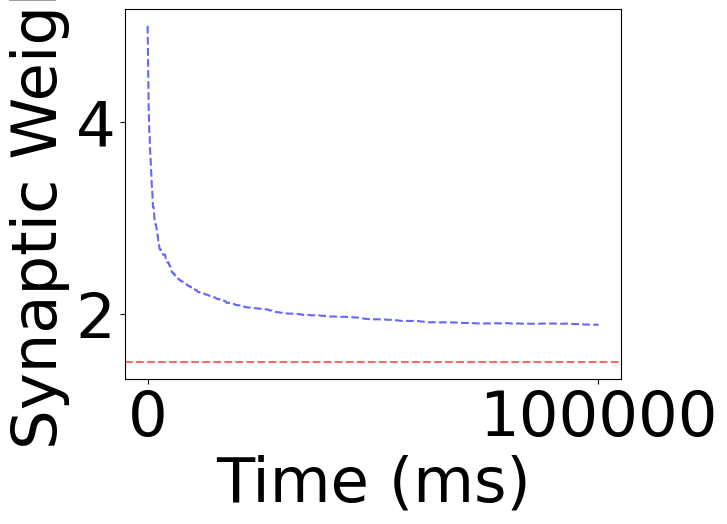

In [27]:
plt.plot(np.linspace(0, time, timesteps), E_target, '--b', alpha = 0.6);
#plt.plot(np.linspace(0, time, timesteps), I_target, '--R', alpha = 0.6);
plt.axhline(y = i_target, linestyle ='--', color = 'r', alpha = 0.6);
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic Weight')

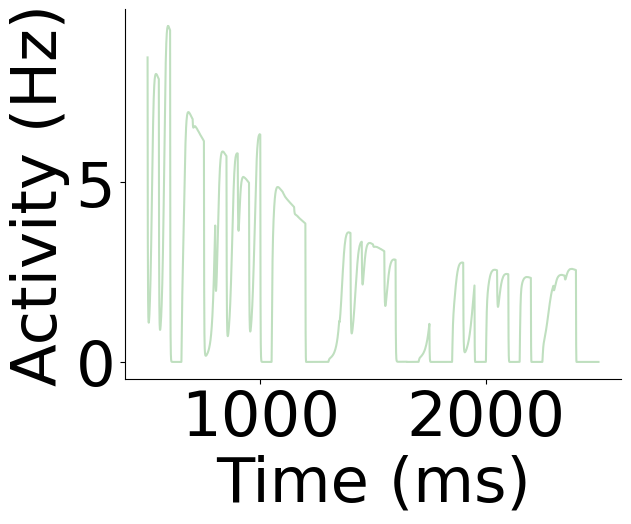

In [28]:
plt.plot(np.linspace(0, time, timesteps-1)[5000:25000], r[5000:25000], color = 'g', alpha = 0.25);
plt.xlabel('Time (ms)')
plt.ylabel('Activity (Hz)')
sns.despine()

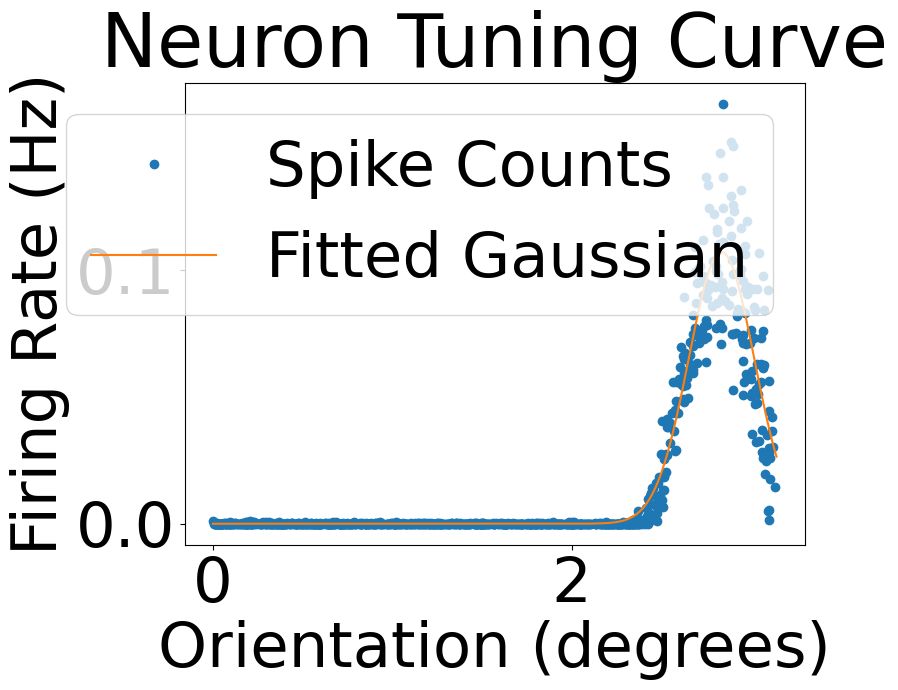

Fitted Parameters: A=0.10710975886978095, mu=2.8350923392363003, sigma=-0.18325779780184911


In [29]:
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2 * sigma**2))

# Take the last half of the data - why? Because at the beginning the network is not stable
l = int(len(angle)//2)
x = angle[-l:]
y = np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:]
    

popt, pcov = curve_fit(gaussian, x, y, 
                       maxfev = 150000)
# p0=[0.05, 1.570, 0.3490]
A, mu, sigma = popt

# Generate data using the fitted parameters
x_fit = np.linspace(0, np.pi, 1000)
y_fit = gaussian(x_fit, A, mu, sigma)

plt.figure(figsize=(8, 6))
plt.plot(angle[-l:], np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:], 'o', label='Spike Counts')
# plt.plot(angle, np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1), 'o', label='Spike Counts')
plt.plot(x_fit, y_fit, '-', label='Fitted Gaussian')
# plt.plot(x_fit, y_act, '.', color = 'g')
plt.xlabel('Orientation (degrees)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Neuron Tuning Curve')
plt.legend()
plt.show()

print(f'Fitted Parameters: A={A}, mu={mu}, sigma={sigma}')

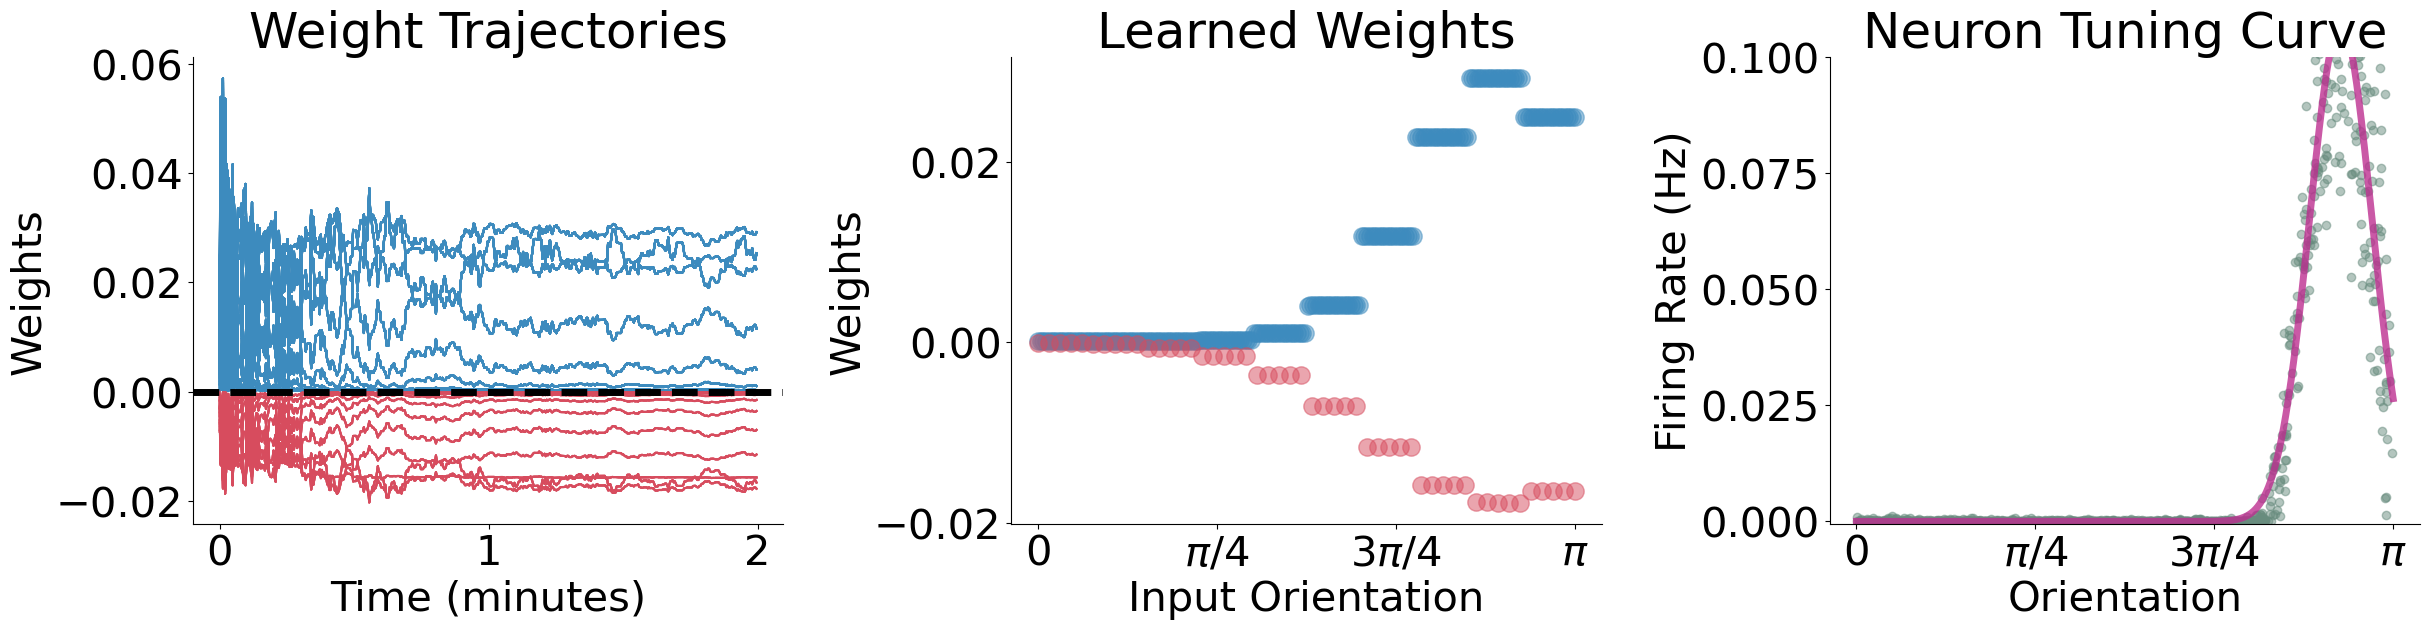

In [30]:
plt.rcParams.update({'font.size': 30})
plt.figure(figsize= (25, 7))


plt.subplot(1, 3, 1)
plt.plot(np.linspace(0, time, timesteps)[::2000], w_e[::2000], color = '#3d8bbeff', alpha = 0.8);
plt.plot(np.linspace(0, time, timesteps)[::2000], -w_i[::2000]/4, color = '#d74c5eff', alpha = 0.8);
plt.axhline(y = 0, linestyle = "--", linewidth = 5.0, color = 'k')
plt.xticks(np.linspace(0, time, 3), ['0', '1', '2'])
plt.xlabel('Time (minutes)')
plt.ylabel('Weights')
plt.title('Weight Trajectories')
sns.despine()

plt.subplot(1, 3, 2)
plt.plot(np.linspace(0, 100, E_inputs), w_e[-1], '.', markersize = 25, color = '#3d8bbeff', alpha = 0.5)
plt.plot(np.linspace(0, 100, I_inputs), -w_i[-1]/4, '.', markersize = 25, color = '#d74c5eff', alpha = 0.5)
plt.xlabel('Input Orientation')
plt.xticks(np.linspace(0, 100, 4), ['0', r'$\pi/4$', r'$3\pi/4$', r'$\pi$'])
plt.ylabel('Weights')
plt.title('Learned Weights')


plt.subplot(1, 3, 3)
plt.plot(angle[-l:], np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:],
         'o',
         label='FR',
         color = '#688c7eca', alpha = 0.5)
        
plt.plot(x_fit, y_fit, '-', label='Gaussian', color = '#bc2d8fca', linewidth = 5)
plt.xticks(np.linspace(0, np.pi, 4), ['0', r'$\pi/4$', r'$3\pi/4$', r'$\pi$'])
plt.xlabel('Orientation')
plt.ylabel('Firing Rate (Hz)')
plt.title('Neuron Tuning Curve')
plt.ylim([-0.0005, 0.1])
sns.despine()

plt.tight_layout()

## SBI simulate for learning rates